## Processsing the results for the annual Summer Irrigated Cropping Area (SICA) project


In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr
import os
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
from multiprocessing import Pool
import sys

### Entire catchment plot

This code will produce a timeseries of annual irrigated area aggregated acrosss the entire Northern Murray Darling Basin

In [ ]:
directory = "results/nmdb/"
suffix = "_Irrigated_LSandOEHandCommission_masked"

In [ ]:
#list of years to help for-loop iterate through folders
x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

folders = os.listdir(directory)
folders.sort()

area_a = []
def getIrrigatedArea(shp):
    irr = gpd.read_file(shp)
    area_a.append(irr.area.sum() / 10000)

#grab sum of irrigated area for each each and add to dataframe
for year, folder in zip(years, folders): 
    #progress indicator
    print("\r", "working on year: " + year, end = '')
    getIrrigatedArea(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")

#convert years back into integers for plot
years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)
#create pandas dataframe
df = pd.DataFrame.from_dict({'year':years_dt, 'irrigated area':area_a})#, '0.75+0.8':area_b, '0.70+0.75+0.8':area_c})
df = df.set_index('year')
df.to_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", header=True)

In [ ]:
#plot annual irrigated area
fontsize = 17
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_annual_area.csv", index_col=0)
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year (Summer Nov-Mar)', fontsize=fontsize)
ax.set_ylabel('Area under Irrigation ($10^5$ Ha)', fontsize=fontsize)
ax.set_ylim(bottom=-int((df['irrigated area'].max()*0.05)), top=(df['irrigated area'].max()+(df['irrigated area'].max()*0.1)))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.axvspan(2010, 2013, alpha=0.4, color='grey')
# ax.set_facecolor('cornsilk')
ax.set_title("Northern MDB Annual Summer Irrigated Area", fontsize=fontsize)
#     plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_irrigated_area.pdf",
           orientation='landscape')

### Sub-catchment plots

This script will produce a timeseries of irrigated area for each subcatchment in the directory.  This script is slow to run beacause the geopandas overlay functions are cumbersome (this is true of other libraries as well). R-tree spatial indexing is NOT used as it is imprecise with the clip boundaries.

In [2]:
directory = "results/nmdb/"
individual_catchments_dir ="/g/data/r78/cb3058/dea-notebooks/ICE_project/data/spatial/nmdb_individual_catchments/"
suffix = "_Irrigated_LSandOEHandCommission_masked"

In [3]:
#generate all the filenames we need for the loops
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(os.path.join(individual_catchments_dir, file))

x = range(1987,2019,1)
years = []
for i in x:
    nextyear = str(i + 1)[2:]
    y = str(i) + "_" + nextyear
    years.append(str(y))
# removing years that didn't work due to bad satellite coverage
years =  [e for e in years if e not in ('2011_12', '2012_13')]
years.sort()

years_dt = []
for i in years:
    x = int(i[:-3])
    years_dt.append(x)

folders = os.listdir(directory)
folders.sort()

In [4]:
#multithreaded version
def subcatchmentarea(catchment):
    print("working on "+ catchment[85:-4])
    area_a = []
    for year, folder in zip(years, folders): 
        #progress indicator
        print("\r", "working on "+ catchment[85:-4] + ": " + year, end = '')
        #get the irrigated area shapefile
        irr = gpd.read_file(directory+folder+"/"+"nmdb_Summer"+ year + suffix+".shp")
        catch = gpd.read_file(catchment)
        irr_clip = gpd.overlay(irr, catch, how='intersection')
        area_a.append(irr_clip.area.sum() / 10000) 
    #create pandas dataframe
    df = pd.DataFrame.from_dict({'year':years_dt, 'irr_area':area_a})
    df = df.set_index('year')
    df.to_csv("results/nmdb_plots/csvs/annual_area/" + catchment[85:-4] + "_annual_area.csv", header=True)
    print(". finished "+ catchment[85:-4])

#singlethreaded version
# for i in catchments:
#     subcatchmentarea(i)

# multithreaded version
pool = Pool(4)    
pool.map(subcatchmentarea, catchments)

working on BORDER RIVERS_QLD
working on MOONIE RIVER
working on CONDAMINE-CULGOA RIVERS
working on PAROO RIVER
 working on PAROO RIVER: 2018_19finished PAROO RIVER
working on CASTLEREAGH RIVER
 working on MOONIE RIVER: 2018_19finished MOONIE RIVER
working on MACQUARIE-BOGAN RIVERS
 working on CASTLEREAGH RIVER: 2018_19finished CASTLEREAGH RIVER
working on GWYDIR RIVER
 working on GWYDIR RIVER: 2018_19finished GWYDIR RIVER
working on DARLING RIVER
 working on MACQUARIE-BOGAN RIVERS: 2018_19finished MACQUARIE-BOGAN RIVERS
working on WARREGO RIVER
 working on DARLING RIVER: 2018_19finished DARLING RIVER
working on NAMOI RIVER
 working on BORDER RIVERS_QLD: 2018_19finished BORDER RIVERS_QLD
working on BORDER_RIVERS_NSW
 working on WARREGO RIVER: 2018_19finished WARREGO RIVER
 working on CONDAMINE-CULGOA RIVERS: 2018_19finished CONDAMINE-CULGOA RIVERS
 working on NAMOI RIVER: 2018_19finished NAMOI RIVER
 working on BORDER_RIVERS_NSW: 2018_19finished BORDER_RIVERS_NSW


[None, None, None, None, None, None, None, None, None, None, None]

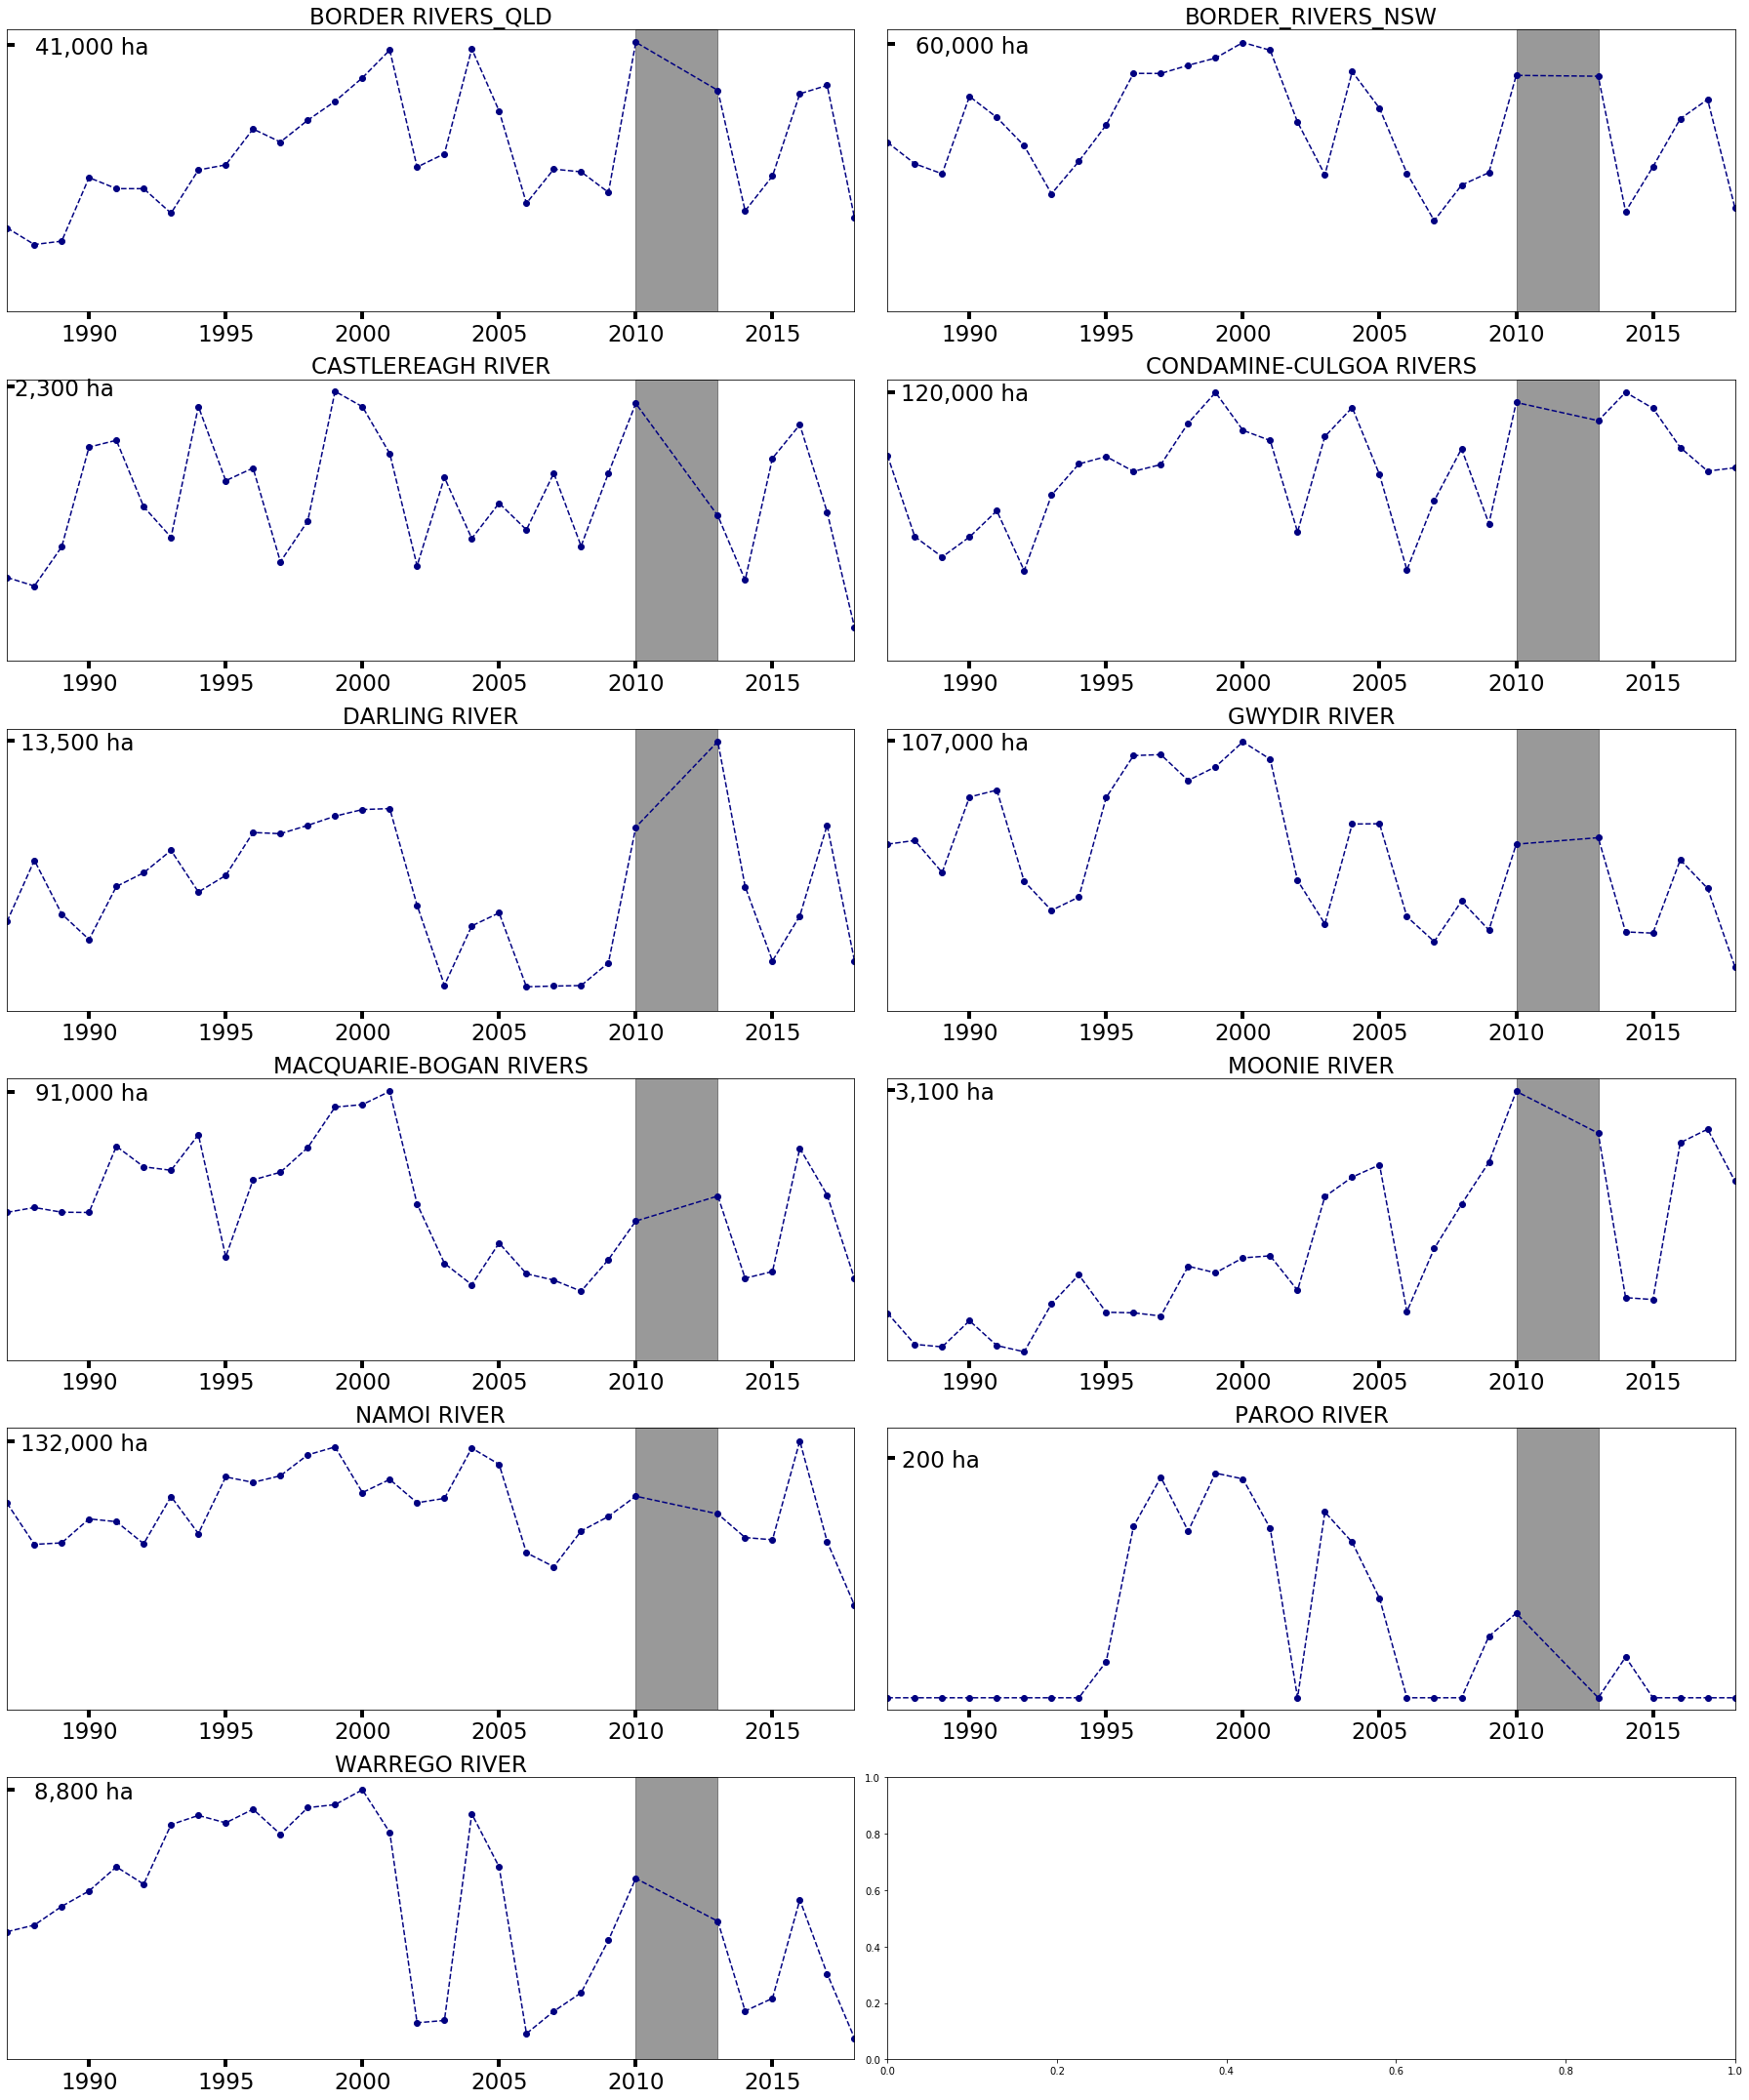

In [5]:
#create plot and save
folder = "results/nmdb_plots/csvs/annual_area/"

fig, axs = plt.subplots(6,2, figsize=(25, 30), facecolor='w', edgecolor='k')
files = os.listdir(folder)
files.sort()

for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
    col_name = 'irr_area'
    if file[:-16] == 'PAROO RIVER':
        t = [200]
        bottom = -10
        top = 225
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([str(i)+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-95)
    elif file[:-16] == 'MOONIE RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -100
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'CASTLEREAGH RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -250
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-110)
    elif file[:-16] == 'DARLING RIVER' or file[:-16] == 'WARREGO RIVER':
        t = [round(int(df[col_name].max()), -2)]
        bottom = -750
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-130)
    else:
        t = [round(int(df[col_name].max()), -3)]
        bottom = -3000
        top = df[col_name].max()+(df[col_name].max()*0.05)
        ax.set_ylim(bottom=bottom, top=top)
        ax.set_yticks(t)
        ax.set_yticklabels([format(i,",")+" ha" for i in t])
        ax.tick_params(axis='y', direction='in', pad=-145)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_label_text("")
#     ax.grid(True, linestyle='--', alpha=0.75, axis='y', color="gray")
    ax.axvspan(2010, 2013, alpha=0.4, color='k')
    ax.tick_params(length=8, width=4,labelsize=fontsize)
    ax.set_title(file[:-16], fontsize=fontsize)
#     ax.set_facecolor('cornsilk')

plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_annual_area_subcatchment.pdf",
   orientation='portrait', dpi=300)

## Novel irrigated areas added each year (inverse of cumulative growth)



The script is divided into four sections

1. The first section cumulatively unions the annual irrigated area files. ie. years 1987-1988 are unioned, then 1987-88-89, then 1987-88-89-90 etc. These unioned shapefiles are exported to a folder called 'interim-NMDB'. This code will take hours to run.

2. The second part of the script finds the difference in irrigated area between adjacent time ranges. ie. difference between '1987-88' and '1987-88-89,' etc.  Shapefiles of the difference are exported, and the difference in area for each year is exported as a csv.

3. The 3rd part of the script clips the results of part 2 to each subcatchment and finds the area, exporting the results as a csv.

4. Plotting of the sub-catchment trends

In [1]:
directory = "results/nmdb/"
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
AOI = "nmdb_Summer"
interim_results = "results/nmdb_plots/shapes/interim/"
suffix = "_Irrigated_LSandOEHandCommission_masked"

#### Part 1.

Creating the cumulatively unioned shapefiles

In [5]:
# create list of time strings for function
timerangelist = [str(t) for t in range(1987,2019,1)]
timerangelist = [e for e in timerangelist if e not in ('2011', '2012')]

In [13]:
def cumulativelyUnion(timerangelist, shapes):
    for t in timerangelist:
        print("\r", "working on "+t, end = '')
        #open the year and add it to a list
        nextyear= str(int(t)+1)[2:]
        irr = gpd.read_file(directory+"nmdb_"+t+"_"+nextyear+"/"+AOI+t+"_"+nextyear+suffix+".shp")
        shapes.append(irr)
        print("..length of [shapes] = "+str(len(shapes)))
        #now do the concatentation & dissolve
        x = pd.concat(shapes)
        x['DISS_ID'] = 1
        x = x.dissolve(by='DISS_ID', aggfunc='sum')
        x['year_range'] = "1987_" + t
        x['catchment'] = "NMDB"
        print("...exporting "+t)
        x.to_file(interim_results+"/NMDB_1987_"+t+".shp")

In [14]:
shapes=[]
cumulativelyUnion(timerangelist,shapes)

 working on 1987..length of [shapes] = 1
...exporting 1987
 working on 1988..length of [shapes] = 2
...exporting 1988
 working on 1989..length of [shapes] = 3
...exporting 1989
 working on 1990..length of [shapes] = 4
...exporting 1990
 working on 1991..length of [shapes] = 5
...exporting 1991
 working on 1992..length of [shapes] = 6
...exporting 1992
 working on 1993..length of [shapes] = 7
...exporting 1993
 working on 1994..length of [shapes] = 8
...exporting 1994
 working on 1995..length of [shapes] = 9
...exporting 1995
 working on 1996..length of [shapes] = 10
...exporting 1996
 working on 1997..length of [shapes] = 11
...exporting 1997
 working on 1998..length of [shapes] = 12
...exporting 1998
 working on 1999..length of [shapes] = 13
...exporting 1999
 working on 2000..length of [shapes] = 14
...exporting 2000
 working on 2001..length of [shapes] = 15
...exporting 2001
 working on 2002..length of [shapes] = 16
...exporting 2002
 working on 2003..length of [shapes] = 17
...expo

#### Part 2. 

calculate new area added each year for the entire basin

In [6]:
def areaofFirstYear(area_list):
    #open the first timerange
    firstyear = gpd.read_file(interim_results + "/NMDB_1987_1987.shp")
    area_list.append((firstyear.area.sum()/ 10000))
        
def getdifferenceAreas(yr1, yr2, area_list):
    df1 = gpd.read_file(interim_results+"/NMDB_1987_"+ yr1 + ".shp")
    df2 = gpd.read_file(interim_results+"/NMDB_1987_"+ yr2 + ".shp")
    diff = gpd.overlay(df2, df1, how='difference')
    diff = diff.explode() #need to explode to filter for small areas
    diff['area_diff'] = diff
    toosmall = diff['area_diff'] >= 100000 #less than 10ha
    diff = diff[toosmall]
    print("...exporting "+yr2+"_minus_"+yr1)
    diff.to_file("results/nmdb_plots/shapes/difference_NMDB/NMDB_"+yr2+"_minus_"+yr1+".shp")
    area_list.append(float(diff.area.sum() / 10000))
        
def runpart2(area_list):
    areaofFirstYear(area_list)
    for i in range(1, len(timerangelist)):
        print("\r", "working on "+ timerangelist[i], end = '')
        getdifferenceAreas(timerangelist[i-1],timerangelist[i], area_list)

In [7]:
area_list = []
# os.mkdir("results/nmdb_plots/shapes/difference_NMDB")
runpart2(area_list)

 working on 1988

ValueError: Wrong number of items passed 5, placement implies 1

#### create csv & plot of new area irrigated each year (rather than cumulative growth)

In [ ]:
diff = []
for file in os.listdir("results/nmdb_plots/shapes/difference_NMDB"):
    if file.endswith(".shp"):
        diff.append(os.path.join("results/nmdb_plots/shapes/difference_NMDB", file))
diff.sort()

In [ ]:
area_list = []
for i in diff:
    x = gpd.read_file(i)
    area_list.append((x.area.sum()/ 10000))

In [ ]:
df = pd.DataFrame(index=timerangelist[1:])
df['NMDB'] = area_list
df.to_csv("results/nmdb_plots/NMDB_new_area_added_each_year.csv", header=True)

In [ ]:
fontsize = 17
df = pd.read_csv("results/nmdb_plots/csvs/NMDB_new_area_added_each_year.csv", index_col=0)
df=df[2:]
ax = df.plot(colormap='jet', linestyle='--', marker='o', legend=False,figsize=(20,8))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlabel('Year Range', fontsize=fontsize)
ax.set_ylabel('Irrigatable Area ($10^4$ Ha)', fontsize=fontsize)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 3), useMathText=True)
# ax.set_ylim(bottom=int((df['NMDB'].max()*0.35)), top=(df['NMDB'].max()+(df['NMDB'].max()*0.05)))
plt.tick_params(labelsize=fontsize)
ax.grid(True, linestyle='--', alpha=0.75, color="gray")
ax.axvspan(2010, 2013, alpha=0.4, color='grey')
# ax.set_facecolor('cornsilk')
ax.set_title("NMDB New Irrigated Areas", fontsize=fontsize)
# plt.tight_layout()
plt.savefig("results/nmdb_plots/plots/NMDB_newAreaAdded.pdf",
           orientation='landscape')

#### Part 3 

Subcatchment new area added each year

In [ ]:
#reset the location strings
individual_catchments_dir ="data/spatial/nmdb_individual_catchments/"
basin_epochs = "results/nmdb_plots/shapes/difference_NMDB/"

# create list of time strings for function
timerangelist = [str(t) for t in range(1987,2019,1)]
timerangelist = [e for e in timerangelist if e not in ('2011', '2012')]

#get a list of catchment names as input to functions
catchments = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchments.append(file[:-4])

#create list of catchment shapefiles
catchment_shps = []
for file in os.listdir(individual_catchments_dir):
    if file.endswith(".shp"):
        catchment_shps.append(os.path.join(individual_catchments_dir, file))

#get list of NMDB difference files 
epochs = []
for file in os.listdir(basin_epochs):
    if file.endswith(".shp"):
        epochs.append(os.path.join(basin_epochs, file))
epochs.sort()

In [ ]:
for catch_shp, catchment in zip(catchment_shps, catchments):
    area_list = []
#     try:
#         print("; working on " + catchment)
#         clipBoundary = gpd.read_file(catch_shp)
#         firstyear = gpd.read_file(interim_results+ "NMDB_1987_1987.shp")
#         firstYearClip = gpd.overlay(firstyear, clipBoundary, how='intersection')
#         area_list.append((firstYearClip.area.sum()/ 10000))
#     except:
#         area_list.append(0)

    for epoch in epochs:
        print("\r", " "+ epoch[47:62], end = '')
        catch = gpd.read_file(catch_shp)
        irr = gpd.read_file(epoch)
        diff = gpd.overlay(irr, catch, how='intersection')
        area_list.append(float(diff.area.sum() / 10000))
    
    df = pd.DataFrame(index=timerangelist[1:])
    df[catchment] = area_list
    df.to_csv("results/nmdb_plots/csvs/newArea/" + catchment + "_new_area.csv", header=True)

#### Part 4 

plotting of sub-catchment new area added each year

In [ ]:
# create plot and save
folder = "results/nmdb_plots/csvs/newArea/"

fig, axs = plt.subplots(6,2, figsize=(25, 30), edgecolor='k')
files = os.listdir(folder)
files.sort()
for ax,file in zip(axs.ravel(), files):
    fontsize = 23
    df = pd.read_csv(folder+file, index_col=0)
    df = df[2:]
    df.plot(ax=ax,colormap='jet', linestyle='--', marker='o', legend = False)
#     if file[:-20] == 'PAROO RIVER':
#         t = [10, 200]
#         bottom = -10
#         top = 225
#         ax.set_ylim(bottom=bottom, top=top)
#         ax.set_yticks(t)
#         ax.set_yticklabels([str(i)+" ha" for i in t])
#         ax.tick_params(axis='y', direction='in', pad=-100)
#     elif file[:-20] == 'MOONIE RIVER':
#         t = [600, round(int(df[file[:-20]].max()), -2)]
#         bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.025
#         top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
#         ax.set_ylim(bottom=bottom, top=top)
#         ax.set_yticks(t)
#         ax.set_yticklabels([format(i,",")+" ha" for i in t])
#         ax.tick_params(axis='y', direction='in', pad=-115)
#     elif file[:-20] == 'CASTLEREAGH RIVER':
#         t = [round(int(df[file[:-20]].min()), -2) , round(int(df[file[:-20]].max()), -3)]
#         bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.3
#         top = df[file[:-20]].max()+(df[file[:-20]].max()*0.1)
#         ax.set_ylim(bottom=bottom, top=top)
#         ax.set_yticks(t)
#         ax.set_yticklabels([format(i,",")+" ha" for i in t])
#         ax.tick_params(axis='y', direction='in', pad=-120)
#     elif file[:-20] == 'WARREGO RIVER':
#         t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
#         bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.2
#         top = df[file[:-20]].max()+(df[file[:-20]].max()*0.075)
#         ax.set_ylim(bottom=bottom, top=top)
#         ax.set_yticks(t)
#         ax.set_yticklabels([format(i,",")+" ha" for i in t])
#         ax.tick_params(axis='y', direction='in', pad=-145)
#     elif file[:-20] == 'DARLING RIVER':
#         t = [round(int(df[file[:-20]].min()), -3) , round(int(df[file[:-20]].max()), -3)]
#         bottom = df[file[:-20]].min() - df[file[:-20]].min()*0.25
#         top = df[file[:-20]].max()+(df[file[:-20]].max()*0.05)
#         ax.set_ylim(bottom=bottom, top=top)
#         ax.set_yticks(t)
#         ax.set_yticklabels([format(i,",")+" ha" for i in t])
#         ax.tick_params(axis='y', direction='in', pad=-145)
#     else:
    t = [round(int(df[file[:-13]].max()), -2)]
    bottom = -5
    top = df[file[:-13]].max()+(df[file[:-13]].max()*0.075)
    ax.set_ylim(bottom=bottom, top=top)
    ax.set_yticks(t)
    ax.set_yticklabels([format(i,",")+" ha" for i in t])
    ax.tick_params(axis='y', direction='in', pad=-125)
    ax.xaxis.set_label_text("")
    ax.tick_params(length=10, width=3, labelsize=fontsize)
    ax.set_title(file[:-13], fontsize=fontsize)
    ax.axvspan(2010, 2013, alpha=0.4, color='grey')
    ax.set_facecolor('cornsilk')
plt.tight_layout()
# plt.savefig("results/nmdb_plots/plots/NMDB_cumulative_area_subcatchment.pdf",
#    orientation='portrait', dpi=300)
plt.savefig("results/nmdb_plots/plots/NMDB_new_area_subcatchment.pdf",
   orientation='portrait', dpi=300)
